# **Data Fest 2021**
## Dmitry Zhvansky
@dzhvansky



---



# **Поиск тестовых коробок в структурированных документах**


---



## **Содержание**
- Возможности OpenCV
- Возможности Tesseract
- Денежный чек
- Вторая страница паспорта
- Преимуществаи ограничения алгоритмической детекции коробок с текстом


---



## **Импорты и установка пакетов**


---



---



In [ ]:
!sudo apt install tesseract-ocr
!sudo apt install tesseract-ocr-rus
!pip install pytesseract

In [ ]:
!git clone https://github.com/dzhvansky/textbox_detector.git

Cloning into 'textbox_detector'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 41 (delta 0), reused 41 (delta 0), pack-reused 0
Unpacking objects: 100% (41/41), done.


In [ ]:
!ls textbox_detector/

data  README.md  requirements.txt  setup.py  textbox_detector


In [ ]:
!pip install -e ./textbox_detector/

Obtaining file:///content/textbox_detector
     |████████████████████████████████| 20.1MB 1.5MB/s 
     |████████████████████████████████| 286kB 41.1MB/s 
     |████████████████████████████████| 13.1MB 168kB/s 
     |████████████████████████████████| 28.2MB 155kB/s 
     |████████████████████████████████| 2.1MB 29.2MB/s 
     |████████████████████████████████| 10.1MB 18.5MB/s 
  Created wheel for imutils: filename=imutils-0.5.3-cp37-none-any.whl size=25850 sha256=f9500dbf5b60ea33e9a2a42ae7568a6e79506045c3aa6da40215d9a84b14b5aa
  Stored in directory: /root/.cache/pip/wheels/16/84/1f/bf88641293cda2c8be81a5c4b8ca973dd9125a6dc3767417fd
Successfully built imutils
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.18.5 which is incompatible.
ERROR: librosa 0.8.0 has requirement joblib>=0.14, but you'll have joblib 0.13.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albume

In [ ]:
import os
import typing
from io import BytesIO
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import cv2
import pytesseract as ts
from PIL import Image, ImageSequence
from PIL.TiffImagePlugin import TiffImageFile

from textbox_detector.tb_detector import TextBoxDetector
from textbox_detector.utils import image_ops

**Функции для чтения картинок**

In [ ]:
def pil_to_cv2(image: Image) -> np.ndarray:
    """
    Convert PIL image to Open CV image
    Args:
        image: PIL image
    Returns: open cv image
    """
    pil_image = image.convert("RGB")
    open_cv_image = np.array(pil_image)
    open_cv_image = open_cv_image[:, :, ::-1].copy()
    return open_cv_image

def bytes_array_to_cv2(images: bytes) -> typing.List[np.ndarray]:
    """
    Convert array of bytes images into the list of cv2 images
    Args:
        images: bytes string image
    Returns: cv2 image
    """
    pil_object = Image.open(BytesIO(images))
    if isinstance(pil_object, TiffImageFile):
        pil_images = ImageSequence.Iterator(pil_object)
    else:
        pil_images = [pil_object]
    return [pil_to_cv2(img) for img in pil_images]

**Функция для OCR методами pytesseract**

In [26]:
def tesseract_ocr(
    image: np.ndarray, 
    preprocess: bool = True,
    scale_width: int = 5000, 
    denoise_kernel_size: int = 21, 
    block_size: int = 255, thresh_weight: int = 24, 
    struct_kernel_size_x: int = 3, struct_kernel_size_y: int = 3, 
    ) -> typing.Tuple[str, np.ndarray]:
    """
    Распознать текст с помощью tesseract OCR
    """

    if preprocess:
      scale_coeff = scale_width / image.shape[1]
      resized = image_ops.resize_by_width(image, scale_width)
      # переводим в серый цвет и чистим от шума
      gray = image_ops.grayscale(resized)
      denoised = image_ops.remove_noise(
          gray, method="gaussian", kernel_size=denoise_kernel_size
      )
      preprocessed = image_ops.process_gray_image(
          denoised, 
          block_size=block_size, 
          thresh_weight=thresh_weight, 
          struct_kernel_size_x=struct_kernel_size_x,
          struct_kernel_size_y=struct_kernel_size_y
      )
    else:
      preprocessed = image.copy()
    
    ocr_string = ts.image_to_string(preprocessed, config='-l rus')
    
    boxes = ts.image_to_boxes(preprocessed, config='-l rus') 
    
    if preprocessed.ndim == 2:
      preprocessed = np.clip(np.stack((preprocessed,) * 3, axis=-1), a_min=50, a_max=255)
    h = preprocessed.shape[0]
    for b in boxes.splitlines():
        b = b.split(' ')
        image = cv2.rectangle(preprocessed, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (255, 0, 0), 1)
        
    return ocr_string, preprocessed

##**Данные**

In [ ]:
parent_dir = Path(".")
data_dir = parent_dir.joinpath("textbox_detector", "data")
orders_dir = data_dir.joinpath("orders")
passports_dir = data_dir.joinpath("passports")

orders = sorted(os.listdir(str(orders_dir)))
passports = sorted(os.listdir(str(passports_dir)))

In [ ]:
orders

['order_1.png', 'order_2.jpg']

In [ ]:
passports

['passp_1.jpg',
 'passp_10.jpg',
 'passp_11.jpg',
 'passp_12.jpg',
 'passp_13.jpg',
 'passp_14.jpg',
 'passp_15.jpg',
 'passp_16.jpg',
 'passp_17.jpg',
 'passp_18.jpg',
 'passp_19.jpg',
 'passp_2.jpg',
 'passp_3.jpg',
 'passp_4.jpg',
 'passp_5.jpg',
 'passp_6.jpg',
 'passp_7.jpg',
 'passp_8.jpg',
 'passp_9.jpg']

## **Денежные чеки**
- Задача: найти и распознать серию и номер чека

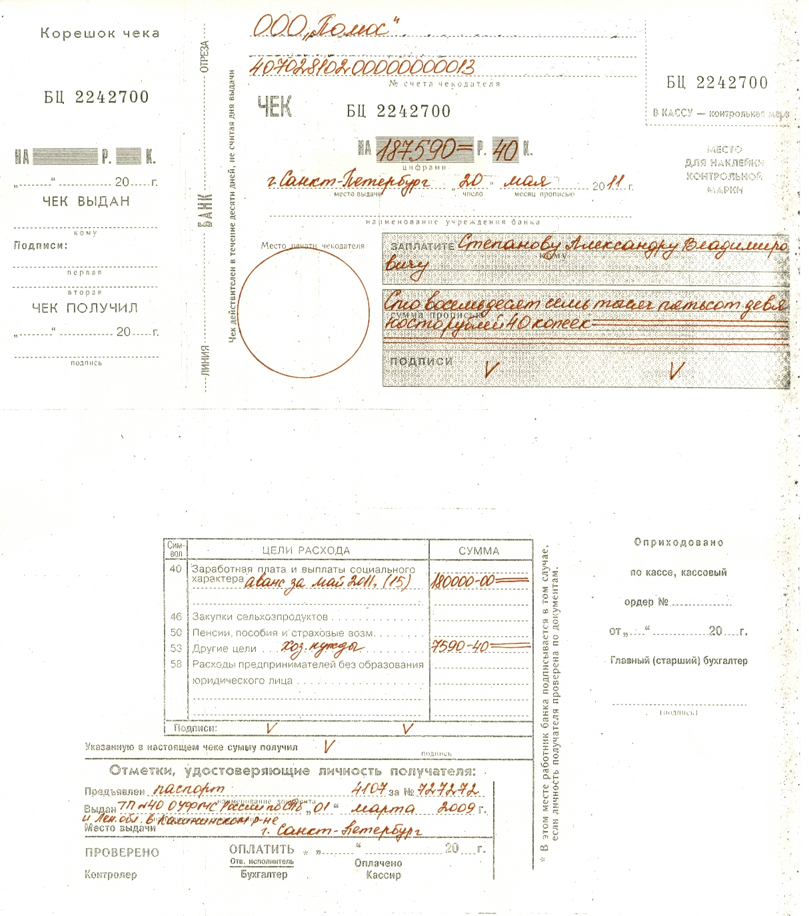

In [ ]:
with open(str(orders_dir.joinpath(orders[0])), 'rb') as f:
    image = bytes_array_to_cv2(f.read())[0]

Image.fromarray(image)

Корешок чека

отт

БИ 2242700

 

А ав р. БЕЯ
- 20...

_ к брт
ЧЕК ВЫДАН

 

 

 

ЧЕК ПОЛУЧИЛ
т

БАНК
“Че действителен в течение лескти дней, не считья ня выдичи

 

   

„линия ----

 

ЦЕЛИ РАСХОДА СУММА

 

ОН 1, (25).

   

46 | Закизки сельхозпродуктов =
50 | пенсии. пособия и страховые возм
53 | Дриие цели . . 2590 -—0===
58 | Расхоль предпринИЧателей без образования |. .

поридического лица

 

 

 

 

рее -

Укоданную в настоящем чоко сумму полю И

 

 

Отметки, удостоверяющие личность получателя:

 

 

 

Проди ИОН вы АА,

‘Выдан7Л =ИО СУЗРИЧС УВЫ 2, 0/ =. вевиета.....#909 г.

ео вы и бели

ПРОВЕРЕНО. ОПЛАТИТЬ „ ». — 20....г.
2. мениеь `Оплачено

Конпролер Битер ассир

 

 

> В лом месте работник банка подписывастся в том случае,
ел личность получателя проверена по документам.

БЦ 2242700

АСУ — поирольние б

    

Оприходовано

по кассе, кассовый

‘ордер № ....

 

от, 20...

Главный (старший) бухалтер



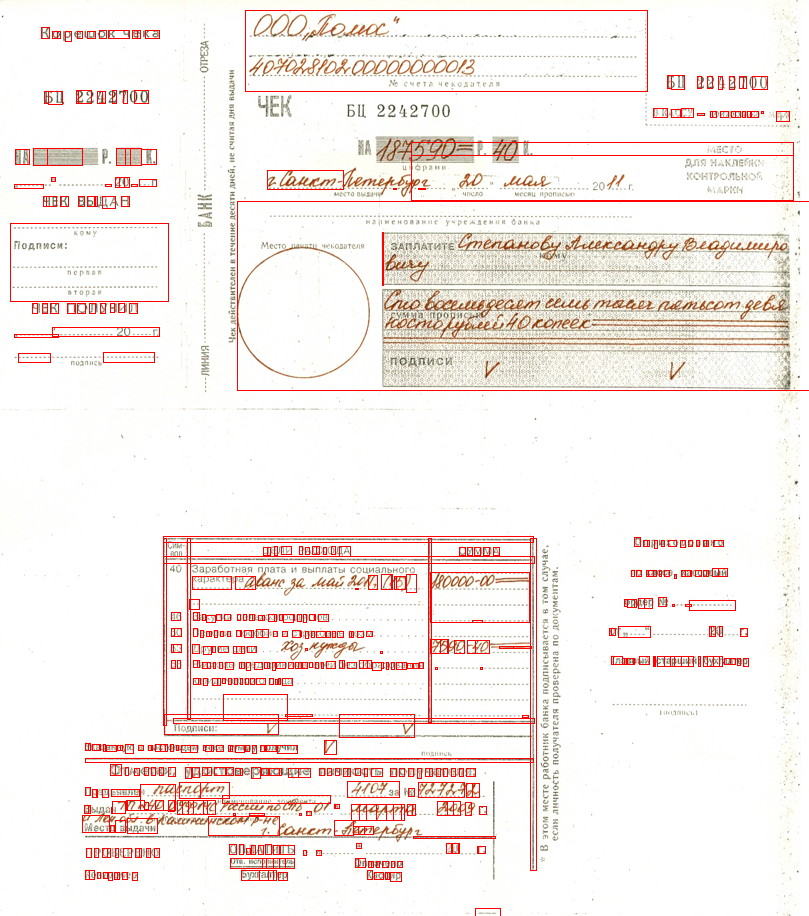

In [28]:
text, img = tesseract_ocr(image, preprocess=False)
print(text)
Image.fromarray(img)

- Tesseract неплохо находит коробки с буквами, но допускает неожиданные ошибки в распознавании. Часть коробок по непонятной причине игнорирует
- Коробки tesseract не подъодят для разметки (их необходимо объединять и расширять)

- **Выделим нужную область методоами OpenCV:**

(альтернатива - SSD)

In [29]:
order_coords = image_ops.get_filled_areas(image)
img1 = image_ops.crop_rotated_rect(image, order_coords[0])
img2 = image_ops.crop_rotated_rect(image, order_coords[1])

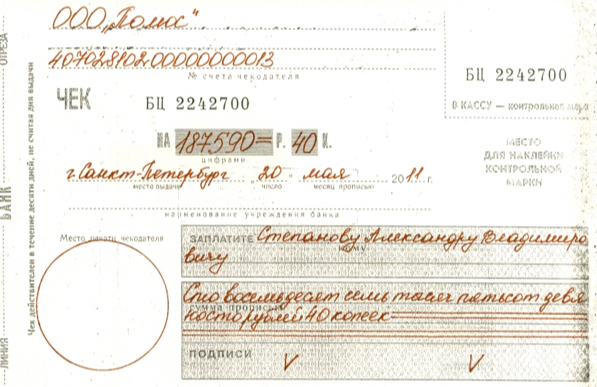

In [30]:
Image.fromarray(img1)

- **Зафиксируем для чеков параметры обработки**
1. Препроцессинг (рескейлинг, бинаризация, морф. трансформация)
2. Области поиска серии-номера
3. Параметры поиска отдельных коробок (букв)
4. Параметры объединения коробок
5. Параметры фильтрации коробок

In [33]:
order_params = {
    "preproc_params": {
        "scale_width": 5000,
        "denoise_kernel_size": 21,
        "first": {
            "block_size": 255,
            "thresh_weight": 36,
            "struct_kernel_size_x": 3,
            "struct_kernel_size_y": 1
        },
        "second": {
            "block_size": 255,
            "thresh_weight": 36,
            "struct_kernel_size_x": 2,
            "struct_kernel_size_y": 1
        },
    },
    "crop_params": {
        "first": {
            "x_start": 0.15,
            "x_end": 0.73,
            "y_start": 0.13,
            "y_end": 0.32,
            "part_width": 512,
            "part_height": 128,
            "angle": 0,
        },
        "second": {
            "x_start": 0.65,
            "x_end": 1.0,
            "y_start": 0.12,
            "y_end": 0.66,
            "part_width": 256,
            "part_height": 256,
            "angle": 0,
        },
    }, 
    "detection_params": {
        "first": {
            "n_boxes": 50,
            "min_height": 0.12,
            "max_height": 0.24,
            "max_width": 0.31,
            "max_area": 0.043,
        },
        "second": {
            "n_boxes": 50,
            "min_height": 0.04,
            "max_height": 0.085,
            "max_width": 0.65,
            "max_area": 0.042,
        },
    }, 
    "merge_params": {
        "first": {"height_lim": 0.032, "width_lim": 0.021},
        "second": {"height_lim": 0.0124, "width_lim": 0.043},
    }, 
    "filter_params": {
        "first": {
            "min_width": 0.03,
            "max_width": 0.27,
            "height_delta": 0.015,
            "angle_delta": 8.0,
        },
        "second": {
            "min_width": 0.05,
            "max_width": 0.4,
            "height_delta": 0.02,
            "angle_delta": 4.0,
        },
    },
    "expand_params": {
        "relative": {"top": 0.15, "bottom": 0.15},
        "absolute": {"left": 0.008, "right": 0.008}
    },
}


In [34]:
order_tbd = TextBoxDetector(
    area_tags=["first", "second"],
    **order_params, 
    boxes_tagging={"first": None, "second": None}, 
    calc_thresh_weight={"first": None, "second": None},
    debug=True
)

<Figure size 432x288 with 0 Axes>

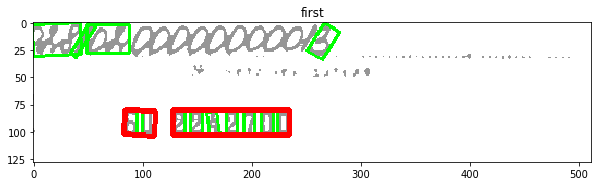

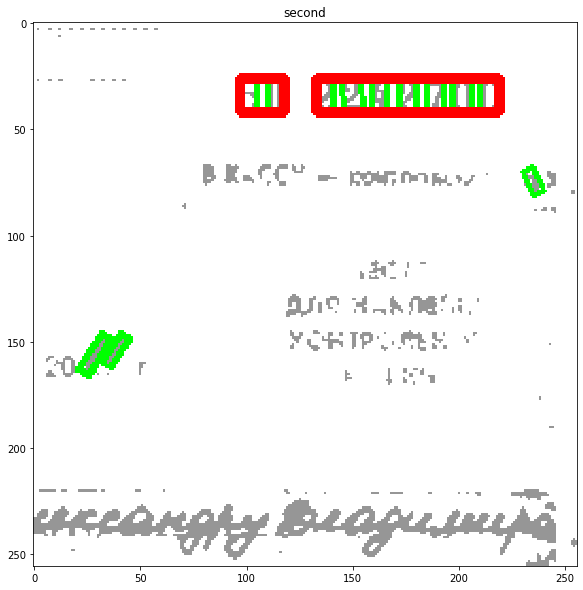

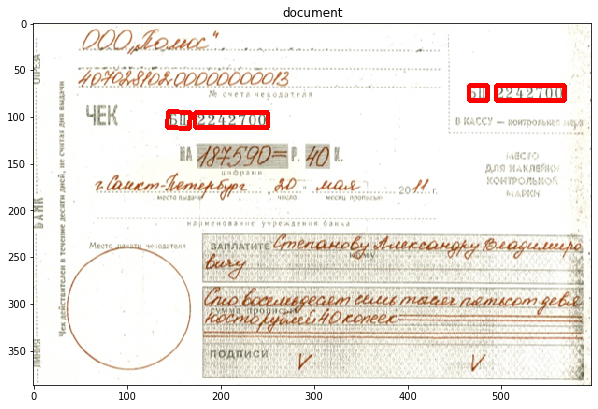

In [35]:
_ = order_tbd.process_document(img1)

- **Проверим для другого чека**

In [36]:
with open(str(orders_dir.joinpath(orders[1])), 'rb') as f:
    image = bytes_array_to_cv2(f.read())[0]

000" "Биолат".

 

5
2 " 20100900088088б6
лат БР 7377224

 

ЧЕК БР 7371224 ВСС пров но

  
 
   

 

ВАА
стве а тени си а, м ситно  чи

 

ЦЕЛИ РАСХОДА суммх

 

тр Са ааа? 20?

46 | Звкутьи сельмозеродусти:

83 Дрим

8 Раохолы предприениателой 6 образования
орион

 

 

 

 

 

 

 

 

 

 

 
 
 

ай 7 627
РИ.

    
 
  

 

Контролер



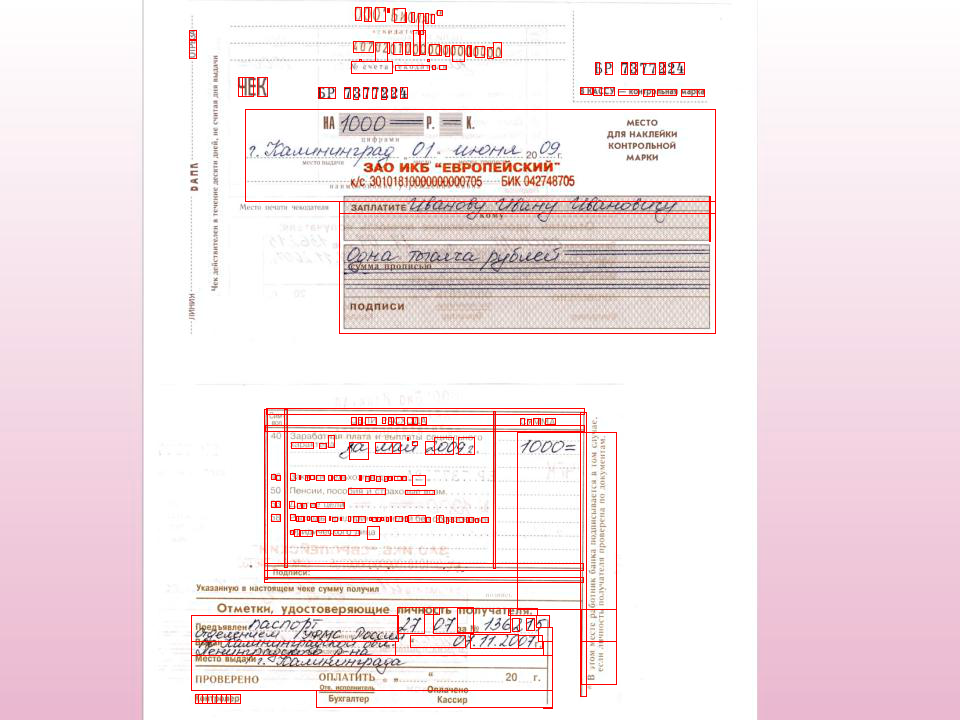

In [37]:
text, img = tesseract_ocr(image, preprocess=False)
print(text)
Image.fromarray(img)

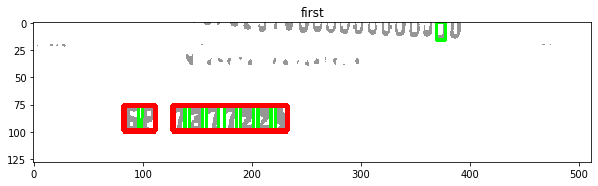

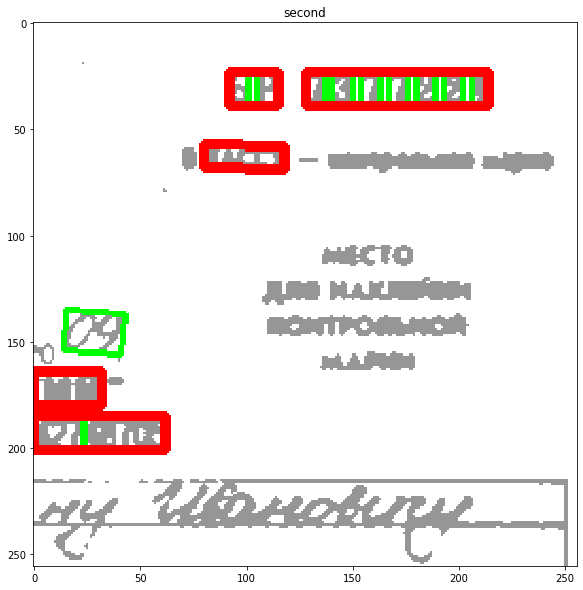

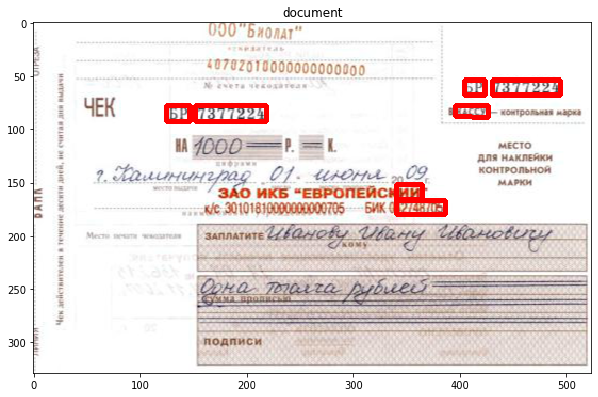

In [38]:
order_coords = image_ops.get_filled_areas(image)
img1 = image_ops.crop_rotated_rect(image, order_coords[0])
_ = order_tbd.process_document(img1)

1. **Коробки находятся хорошо, можно легко протэггировать серию и номер отдельно в обеих областях чека**
2. **Можно использовать найденные коробки для разметки и обучения собственной модели OCR**

## Паспорт РФ

- **Задача: найти коробки с текстом, а также серию и номер документа на второй странице паспорта**

In [43]:
with open(str(passports_dir.joinpath(passports[1])), 'rb') as f:
    image = bytes_array_to_cv2(f.read())[0]
Image.fromarray(image)

Output hidden; open in https://colab.research.google.com to view.

In [44]:
text, img = tesseract_ocr(image, preprocess=False)
print(text)
Image.fromarray(img)

Output hidden; open in https://colab.research.google.com to view.

- **Без предобработки tesseract не справляется, очистим и бинаризуем картинку**

Дето вое ом

 

. ОТДКЛОМ УФМС РОССИИ

ПО САРАТОВСКОЙ ОБЛАСТИ

. . ГОРОДКЕ ЭНИГЕЛЬСВ
. О7. 141 ® 201 4... род о1702®

©40—044

 

` э ”

совет п



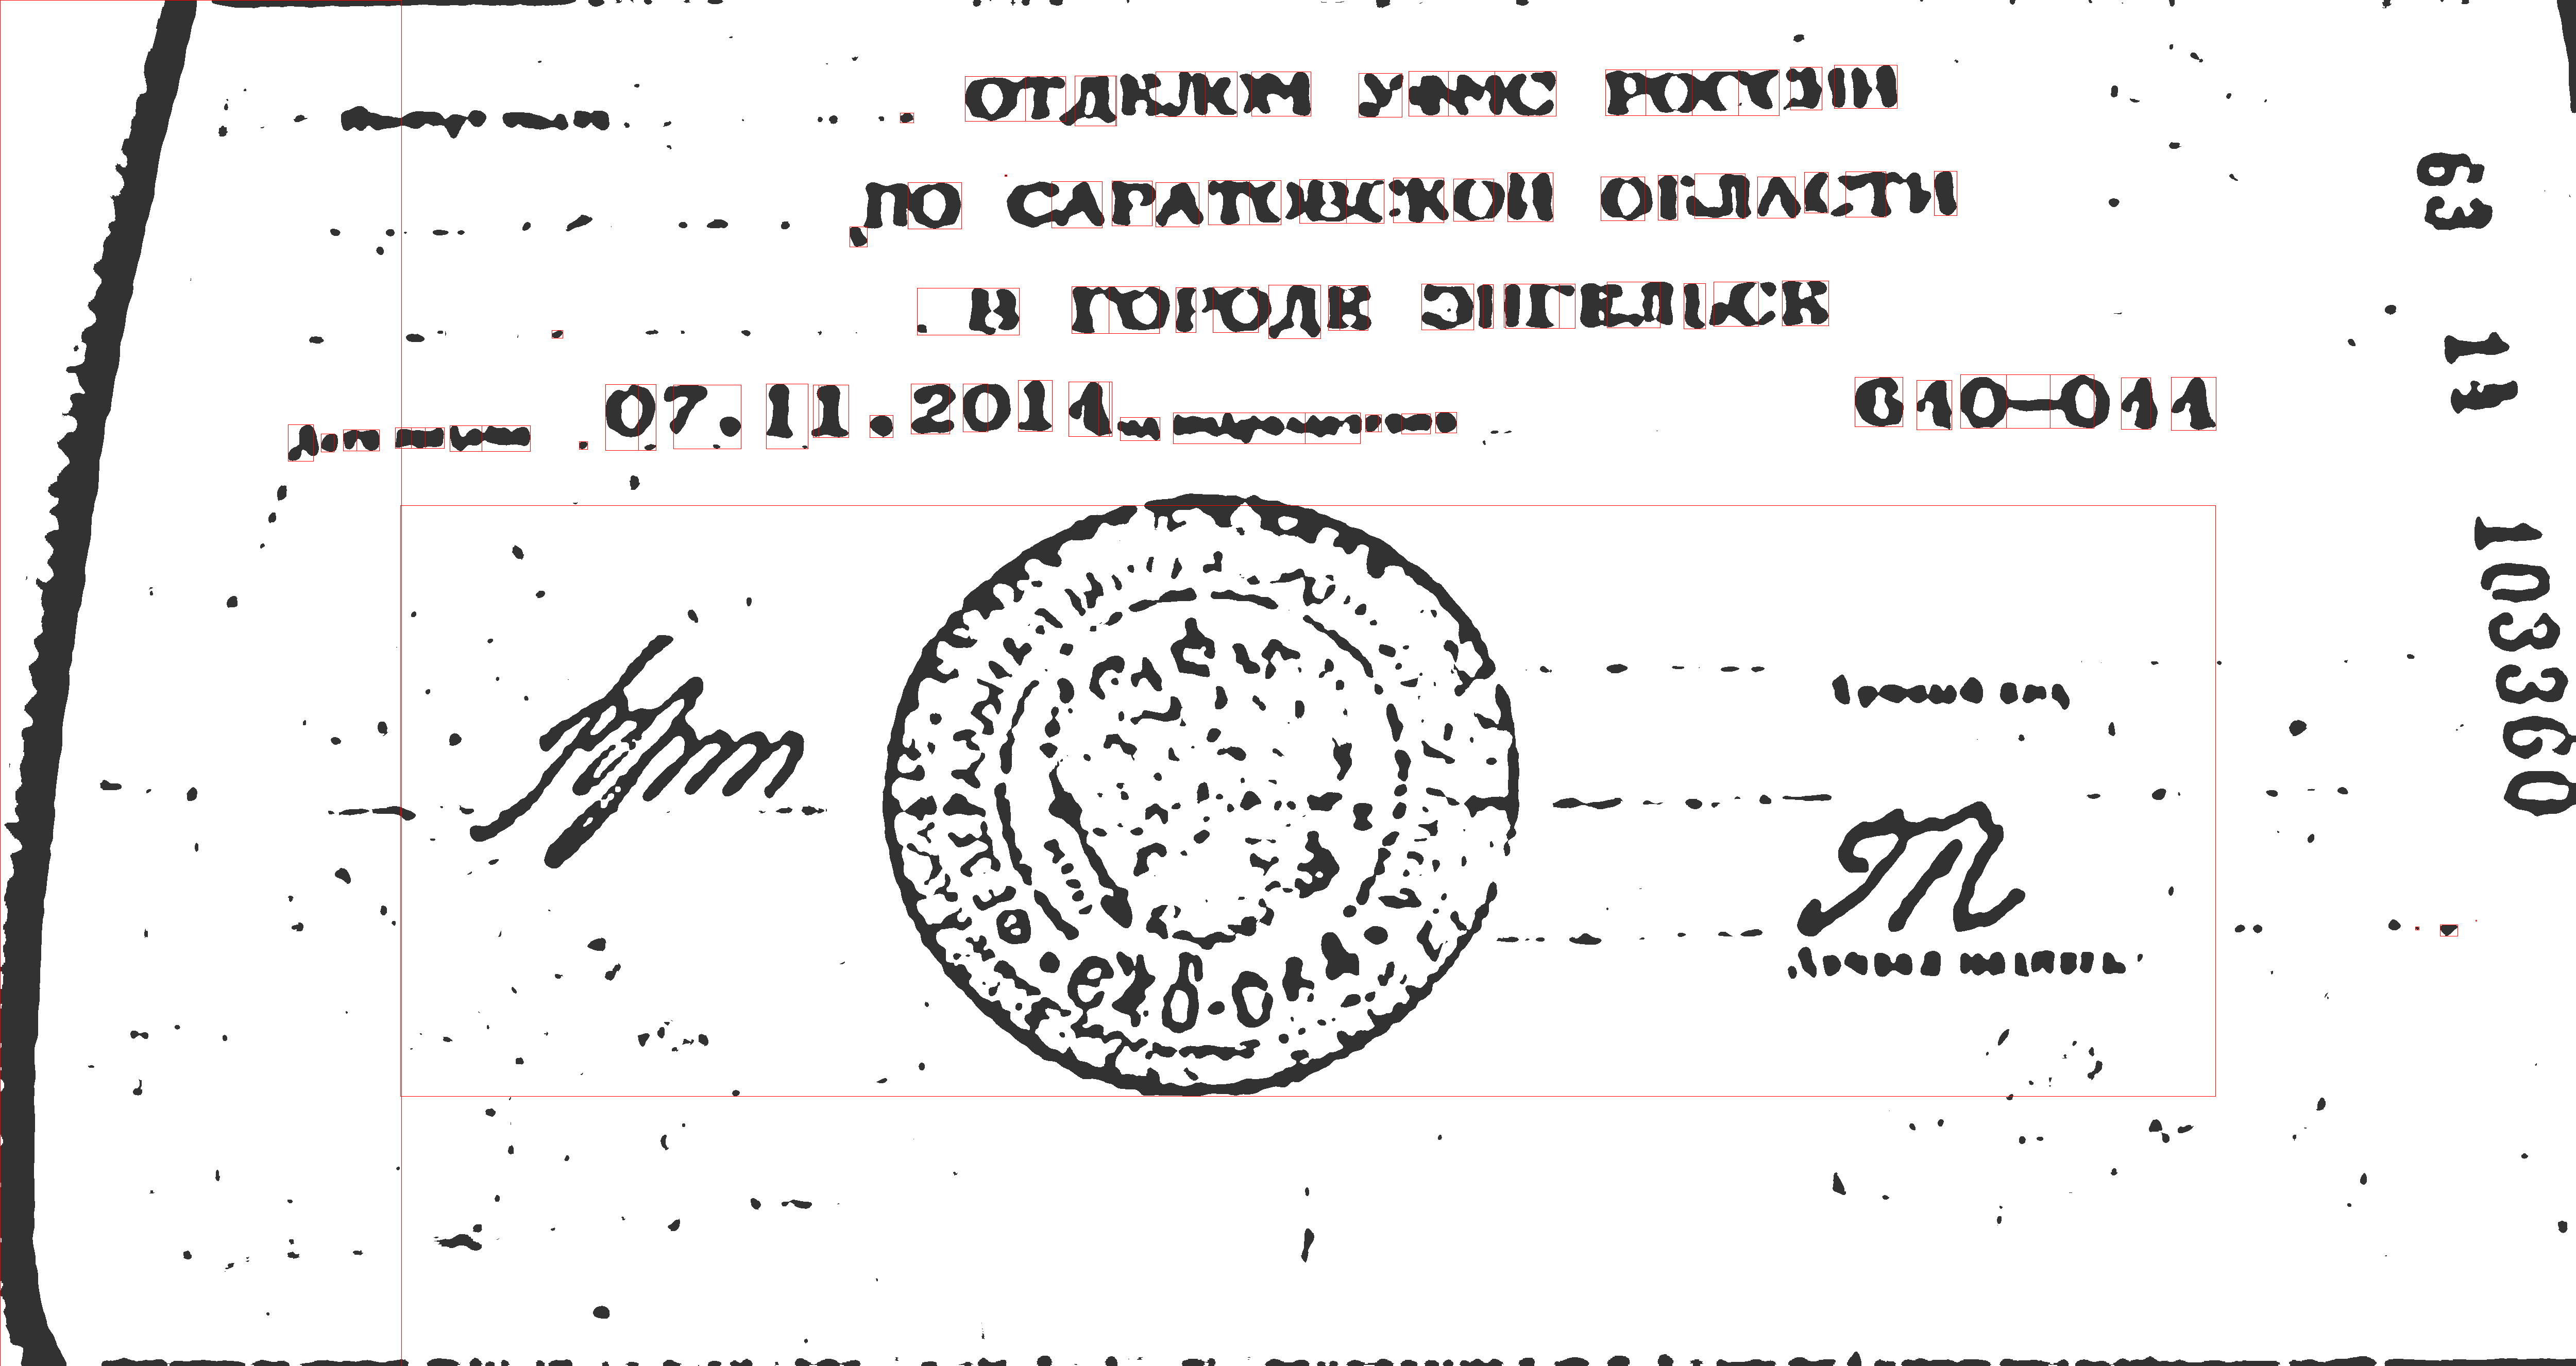

In [47]:
text, img = tesseract_ocr(image, preprocess=True, thresh_weight=8)
print(text)
Image.fromarray(img)

- **Результат чуть лучше, но до приемлемого качества далеко, посмотрим, что получится с серией-номером**

. ©
6“
°

у

‚ чае 646 бовьа\

. о ‚/ 9--
У . .

 

Ст . А че уноео у _

©”

п

4 . |
2594 т О-о фе е ле “ТО "ТТ-ЛО `` ооо = УТ
+4 | — | | . | ”

чоагаялис яуозол я
о

иломечю иозлаодмуауо’ оц’ ^

® -

НЮ ОА ВОГУУО

’ батчьо орд .Ф

 



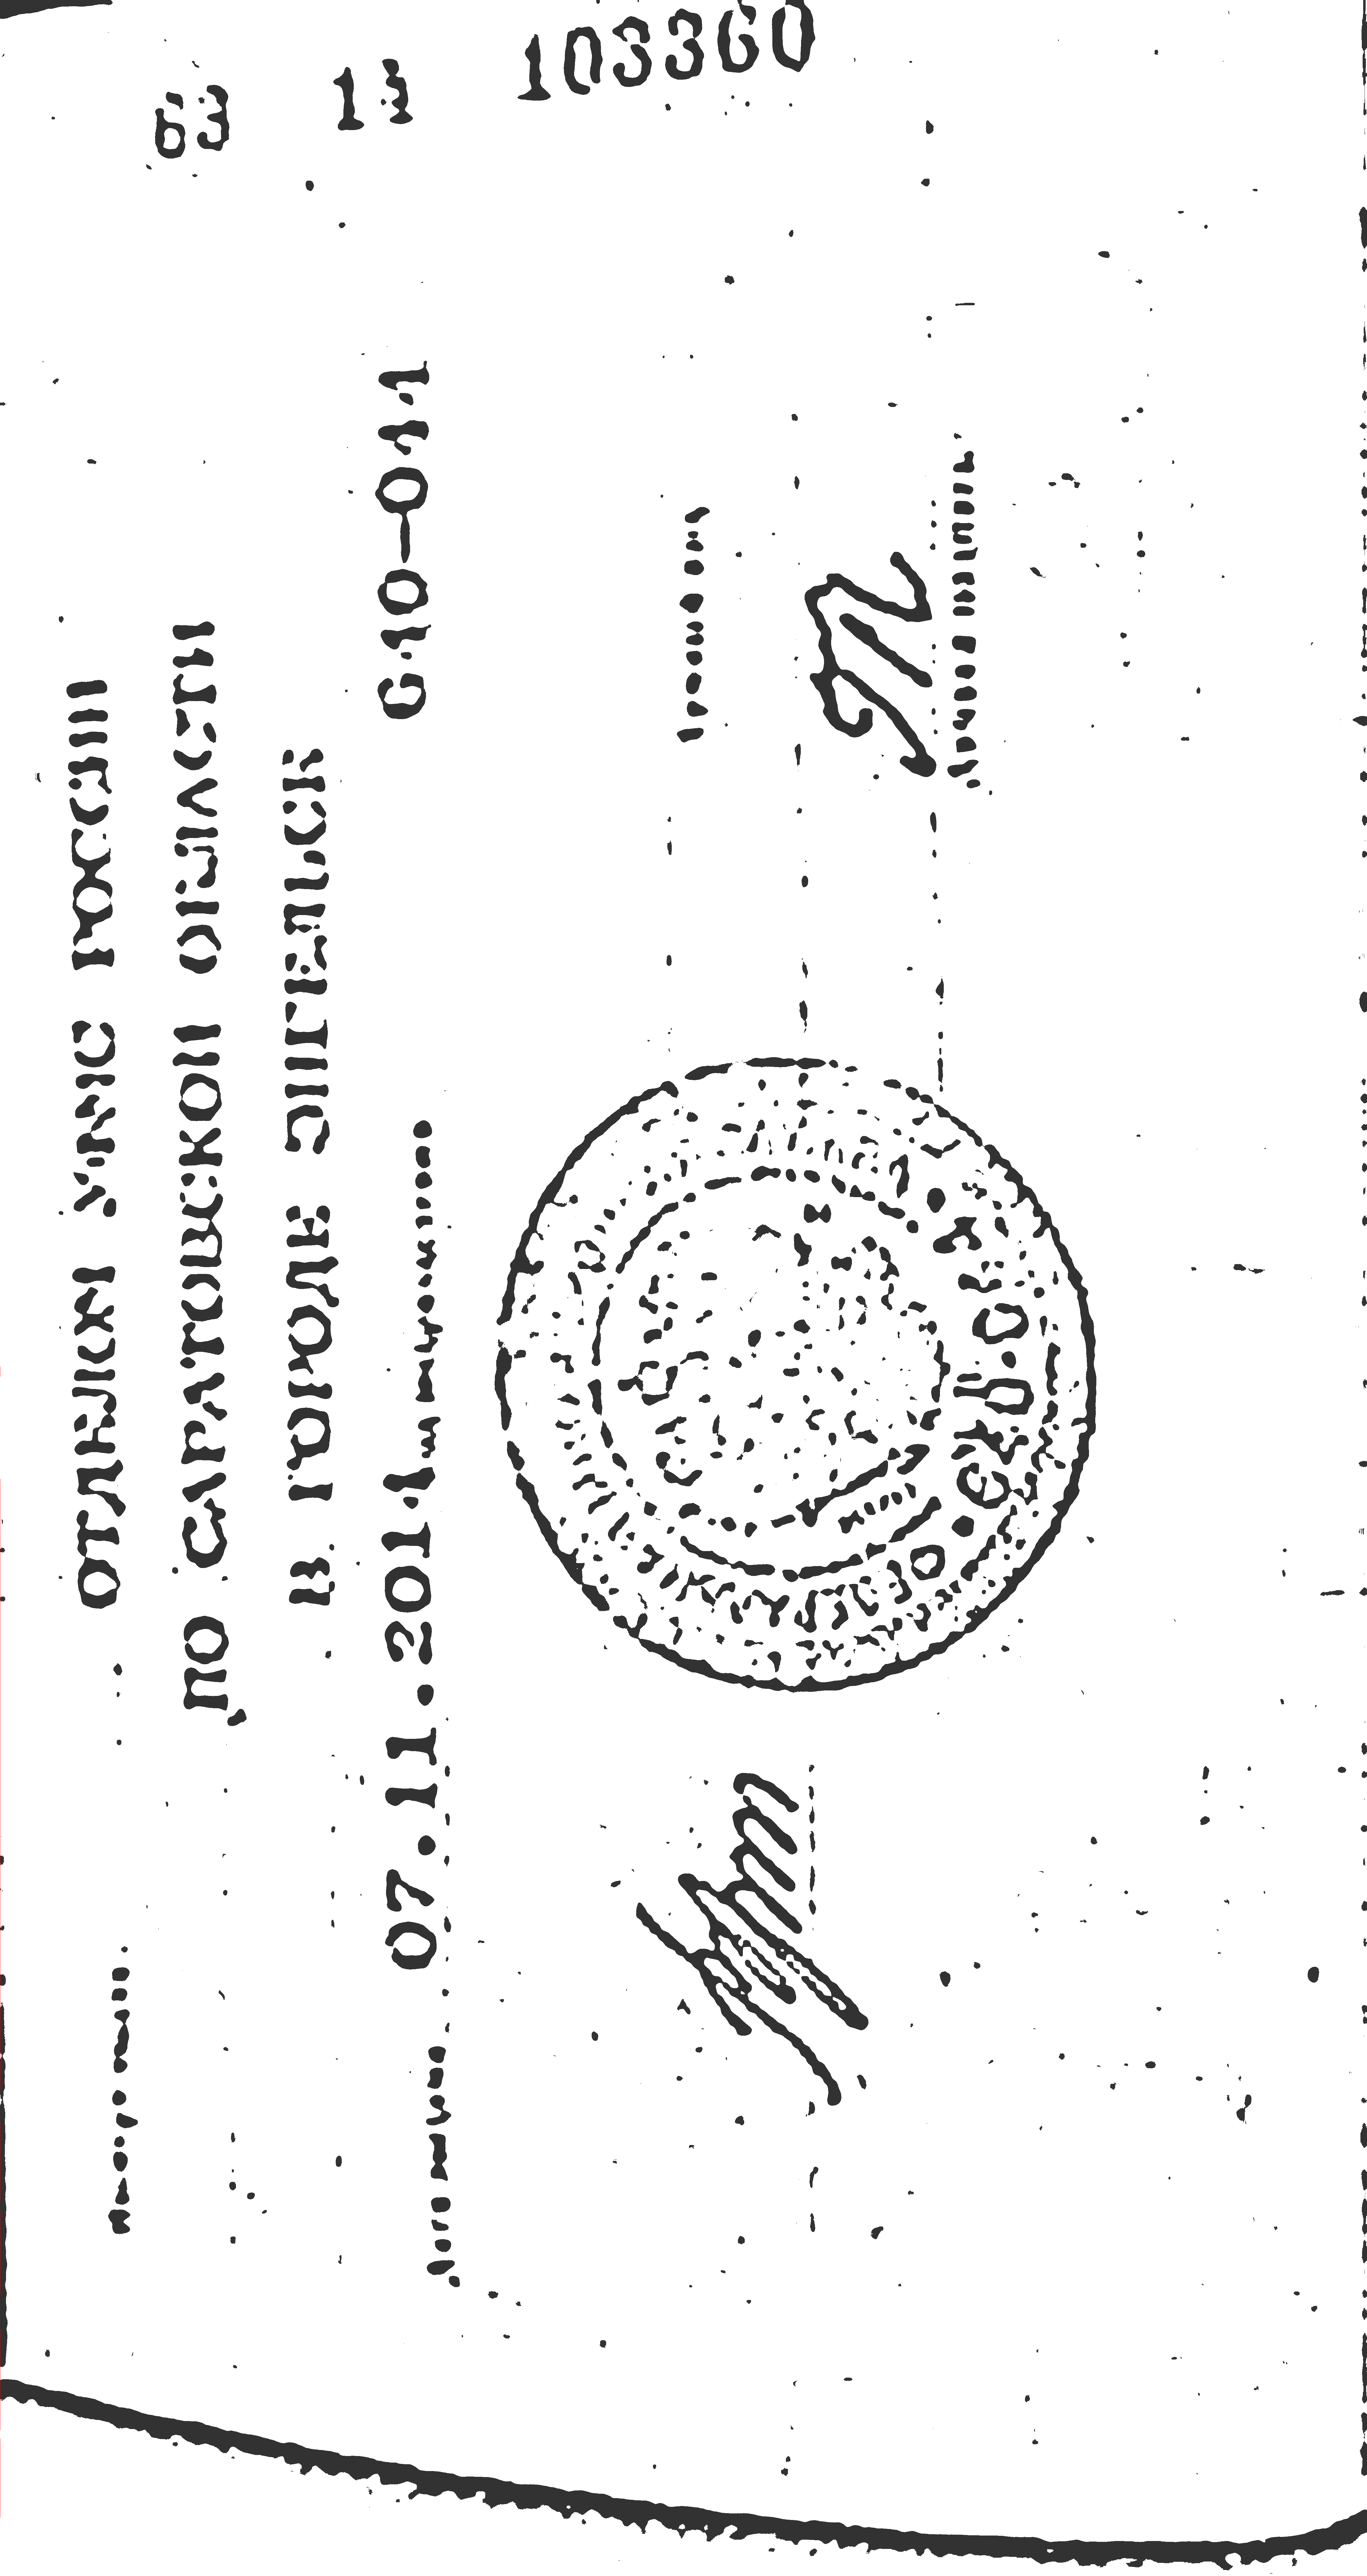

In [48]:
text, img = tesseract_ocr(cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE), preprocess=True, thresh_weight=8)
print(text)
Image.fromarray(img)

- **Здесь еще хуже - из-за наклона текста и в целом перпендикулярного расположения страницы**

- **Воспользуемся детектором коробок, зададим параметры, специфические для паспорта**

In [52]:
passp_params = {
    "preproc_params": {
        "scale_width": 5000,
        "denoise_kernel_size": 21,
        "page2": {
            "block_size": 255,
            "thresh_weight": 20,
            "struct_kernel_size_x": 3,
            "struct_kernel_size_y": 5
        },
        "sn": {
            "block_size": 255,
            "thresh_weight": 24,
            "struct_kernel_size_x": 5,
            "struct_kernel_size_y": 3
        },
    },
    "crop_params": {
        "page2": {
            "x_start": 0.05,
            "x_end": 1.0,
            "y_start": 0.05,
            "y_end": 0.55,
            "part_width": 1024,
            "part_height": 1024,
            "angle": 0,
        },
        "sn": {
            "x_start": 0.8,
            "x_end": 1.0,
            "y_start": 0.1,
            "y_end": 0.95,
            "part_width": 256,
            "part_height": 1024,
            "angle": 90,
        },
    }, 
    "detection_params": {
        "page2": {
            "n_boxes": 120,
            "min_height": 0.045,
            "max_height": 0.13,
            "max_width": 0.31,
            "max_area": 0.043,
        },
        "sn": {
            "n_boxes": 60,
            "min_height": 0.055,
            "max_height": 0.196,
            "max_width": 0.65,
            "max_area": 0.042,
        },
    }, 
    "merge_params": {
        "page2": {"height_lim": 0.022, "width_lim": 0.045},
        "sn": {"height_lim": 0.052, "width_lim": 0.033},
    }, 
    "filter_params": {
        "page2": {
            "min_width": 0.05,
            "max_width": 0.95,
            "height_delta": 0.02,
            "angle_delta": 6.0,
        },
        "sn": {
            "min_width": 0.04,
            "max_width": 0.4,
            "height_delta": 0.05,
            "angle_delta": 18.0,
        },
    },
    "expand_params": {
        "relative": {"top": 0.2, "bottom": 0.2},
        "absolute": {"left": 0.01, "right": 0.01}
    },
}

In [53]:
passp_tbd = TextBoxDetector(
    area_tags=["page2", "sn"],
    **passp_params, 
    boxes_tagging={"page2": None, "sn": None}, 
    calc_thresh_weight={"page2": None, "sn": None},
    debug=True
)

<Figure size 432x288 with 0 Axes>

- **В случае фотографий документов ключевую роль играет параметр tresh_weight. Он используется для бинаризации методом adaptive threshold. Этот параметр необходимо либо подбирать перебором, либо с помощью специальной функции**

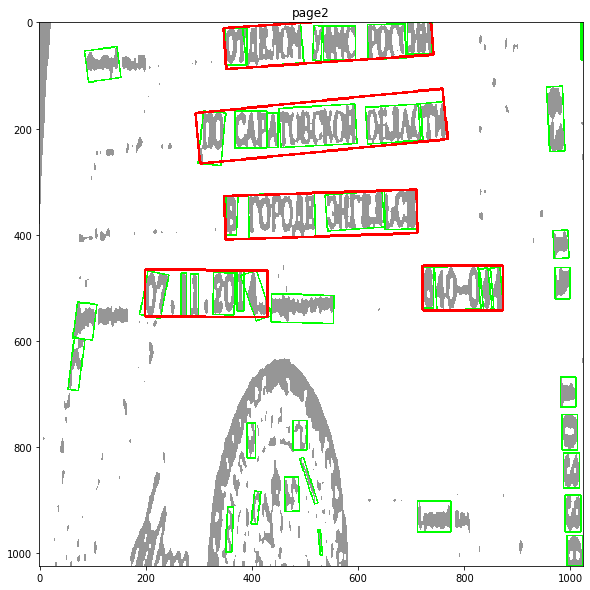

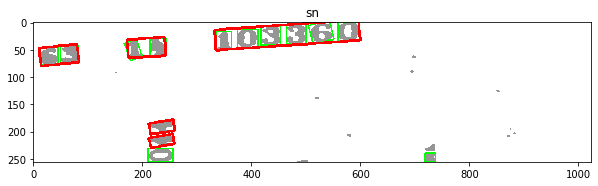

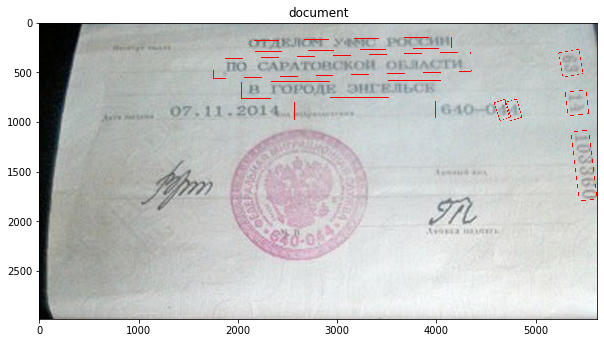

In [54]:
passp_tbd.preproc_params["page2"]["thresh_weight"] = 8
passp_tbd.preproc_params["sn"]["thresh_weight"] = 12
_ = passp_tbd.process_document(image)

- **Коробки хорошо находятся, можно добавить тэггирование на правилах и по необходимости автоматизировать разметку для OCR**
- **Посмотрим еще один паспорт**

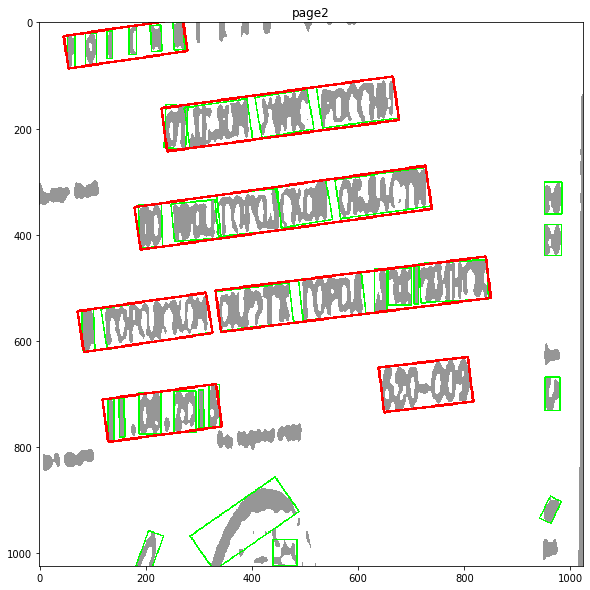

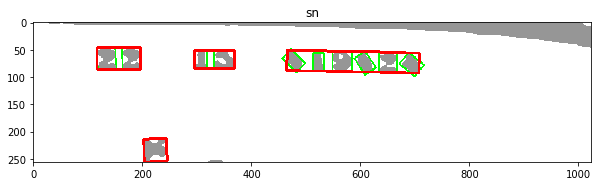

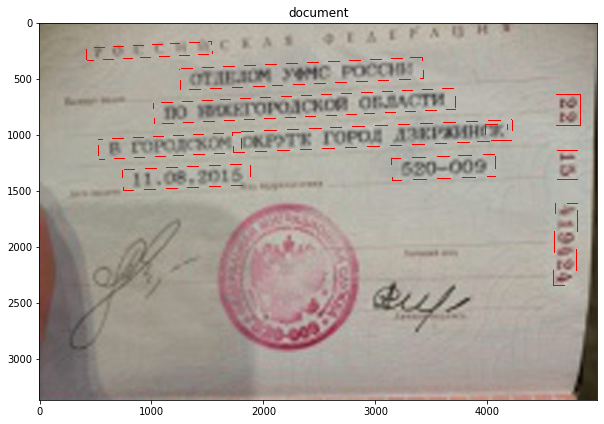

In [55]:
passp_tbd.preproc_params["page2"]["thresh_weight"] = 12
passp_tbd.preproc_params["sn"]["thresh_weight"] = 16
with open(str(passports_dir.joinpath(passports[3])), 'rb') as f:
    image = bytes_array_to_cv2(f.read())[0]
_ = passp_tbd.process_document(image)

- **Посмотрим на качество tesseract (спойлер - все плохо)**

россмис в р %
ПАРОМ $69 РОСС:
тм > эчаргагалскся аг.2%сти
в согахко4 СКР>ТК ГОРОД АЗНРААНСЯ.

11.29.2015... 20-009

до =

 

Е АЕРАОПИ *

гЭ
89

$Т

хАТАХ



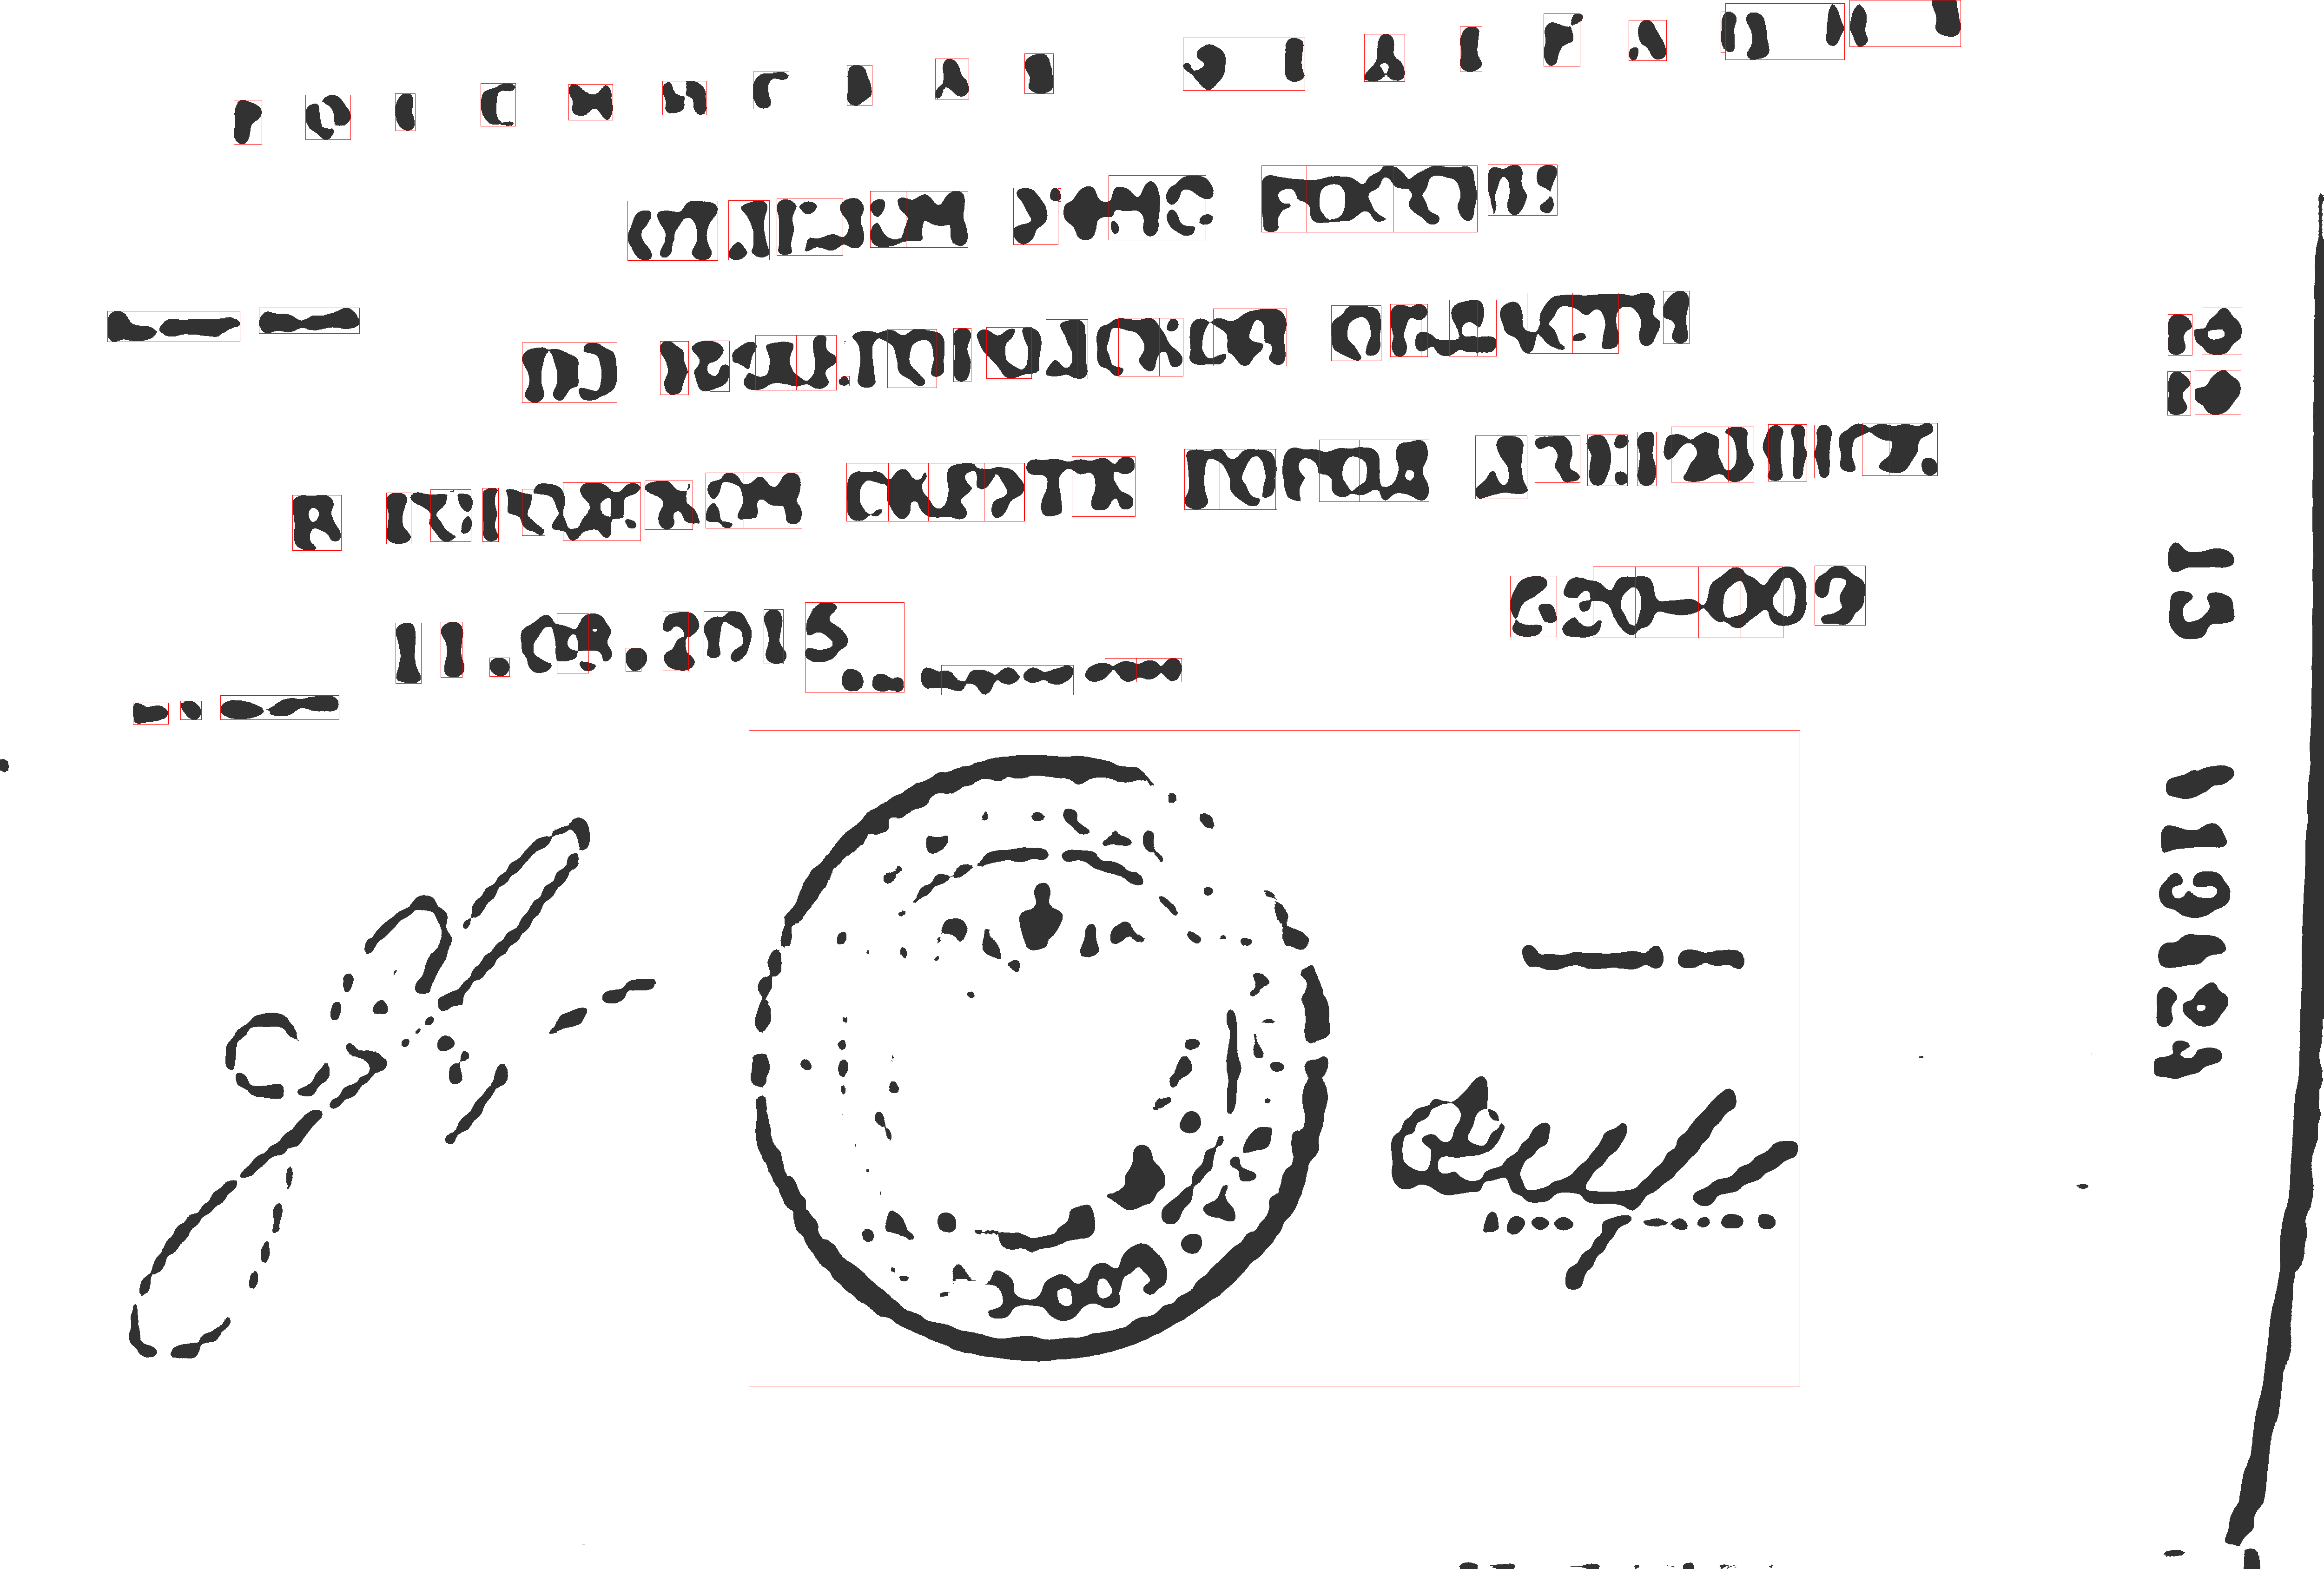

In [60]:
text, img = tesseract_ocr(image, preprocess=True, thresh_weight=12)
print(text)
Image.fromarray(img)

## Выводы 


---
1. Простыми алогритмами и методами OpenCV можно успешно находить коробки с текстом в структурированных документах. 
2. Такой подход позволяет сразу тэггировать сущности, генерировать разметку и обучать собственные OCR модели под конкретную задачу
3. Пайплайн не требователен к железу (легкий инференс)
4. Недостатки: сложный конфиг, индивидуальная сет под каждый документ; необходимость динамической настройки параметров для документов плохого/разного качества
